In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
import time
import os
import warnings
warnings.filterwarnings("ignore")

input_folder = r'C:\Users\A4023862\OneDrive - Astellas Pharma Inc\FPA\SKUtoEquivalized'
output_folder =  r'C:\Users\A4023862\OneDrive - Astellas Pharma Inc\FPA\SKUtoEquivalized\outputs'

######################
# READ IN DATA
######################
input_file = 'analysis\Comparison of BPC to IBP v2.xlsx'
path = os.path.join(input_folder, input_file)
prodv3=pd.read_excel(path, engine='openpyxl', sheet_name = 'prodv3')

bpc_prod=pd.read_excel(path, engine='openpyxl', sheet_name = 'bpc - AsiaPacific')

bpc_sku=pd.read_excel(path, engine='openpyxl', sheet_name = 'bpc_sku')

input_file = r'inputs\tags_mapping.xlsx'
path = os.path.join(input_folder, input_file)
ibpbpc_map=pd.read_excel(path, engine='openpyxl')

C:\Users\A4023862\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\A4023862\\OneDrive - Astellas Pharma Inc\\FPA\\SKUtoEquivalized\\analysis\\Comparison of BPC to IBP v2.xlsx'

In [14]:
######################
# MANIPULATE BPC PRODUCT LEVEL DATA INTO FORMAT
######################
bpcprod=bpc_prod

# Replace column names
columns = list(bpcprod.columns)
columns[0] = 'currency'
columns[1] = 'cost_object'
columns[2] = 'product'
bpcprod.columns = columns

bpcprod=bpcprod.melt(id_vars=["currency", "cost_object", "product"], 
        var_name="ds", 
        value_name="value")

# Extract substring of ds to parse into date
for i in range(0,len(bpcprod['ds'])):
    bpcprod['ds'][i]=bpcprod['ds'][i].split('- FY',1)[1]

# Convert to date
bpcprod['ds'] =  pd.to_datetime(bpcprod['ds'], format='%y %B')
bpcprod['year'], bpcprod['month'], bpcprod['day'] = bpcprod['ds'].dt.year, bpcprod['ds'].dt.month, bpcprod['ds'].dt.day

# Address fiscal year dates
for i in range(0,len(bpcprod['ds'])):
    if bpcprod['month'][i] <4:
        bpcprod['year'][i]=bpcprod['year'][i]+1

# Create new date
bpcprod['ds']=pd.to_datetime(bpcprod[['year', 'month', 'day']])

In [34]:
######################
# GET PROD DATA INTO FORMAT
######################
prod_data = prodv3[['Product Group', 'Customer Country', 'Date', 'equiv_units']]
prod_data.columns = ['product', 'region', 'ds', 'equiv_units']

# Get equiv units by product, region, ds
prod_data = prod_data.groupby(['product','region', 'ds']).sum().reset_index()

In [85]:
######################
# JOIN PROD DATA AND BPC
######################
ibpbpc_map=ibpbpc_map[ibpbpc_map['bpc'].notnull()]
ibpbpc_map_p = ibpbpc_map[ibpbpc_map['type']=='product']
ibpbpc_map_r = ibpbpc_map[ibpbpc_map['type']=='region']

# Replace prod product values with bpc
prod_data2=prod_data.merge(ibpbpc_map_p[['ibp', 'bpc']], how='inner', left_on='product', right_on='ibp')
prod_data2=prod_data2[['bpc', 'region', 'ds', 'equiv_units']]
prod_data2.columns=['product', 'region', 'ds', 'prod_value'] 

# Replace prod region values with bpc
prod_data3=prod_data2.merge(ibpbpc_map_r[['ibp', 'bpc']], how='inner', left_on='region', right_on='ibp')
prod_data3=prod_data3[['product', 'bpc', 'ds', 'prod_value']]
prod_data3.columns=['product', 'region', 'ds', 'prod_value'] 

# Merge prod with bpc
bpcprod=bpcprod[['cost_object', 'product', 'ds', 'value']]
bpcprod['ds']=bpcprod['ds'].astype(str)
data=prod_data3.merge(bpcprod, how='inner', left_on=['product', 'region', 'ds'], right_on=['product','cost_object', 'ds'])

data=data[['region', 'product', 'ds', 'value', 'prod_value']]
data.columns=['product', 'region', 'ds', 'bpc_value', 'prod_value'] 

In [86]:
######################
# GET ROLLING AVERAGE FOR CALCIBP
######################
# Filter data for 2022
data2=data[(data['ds']>='2022-03-01') & (data['ds']<='2022-11-01')]

data2['2m_avg'] = data2.groupby(['product', 'region'])['prod_value'].transform(lambda x: x.rolling(2, 1).mean())
data2['3m_avg'] = data2.groupby(['product', 'region'])['prod_value'].transform(lambda x: x.rolling(3, 1).mean())

# Find the difference % between bpc and prod, 2m and 3m
data2['diff1'] = ((data2['prod_value']-data2['bpc_value']) / data2['bpc_value']) * 100
data2['diff2'] = ((data2['2m_avg']-data2['bpc_value']) / data2['bpc_value']) * 100
data2['diff3'] = ((data2['3m_avg']-data2['bpc_value']) / data2['bpc_value']) * 100

# # Write to csv
# output_folder =  r'C:\Users\A4023862\OneDrive - Astellas Pharma Inc\FPA\SKUtoEquivalized\outputs'
# output_file = 'calcibp_vs_bpc.csv'
# path = os.path.join(output_folder, output_file)
# data.to_csv(path)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

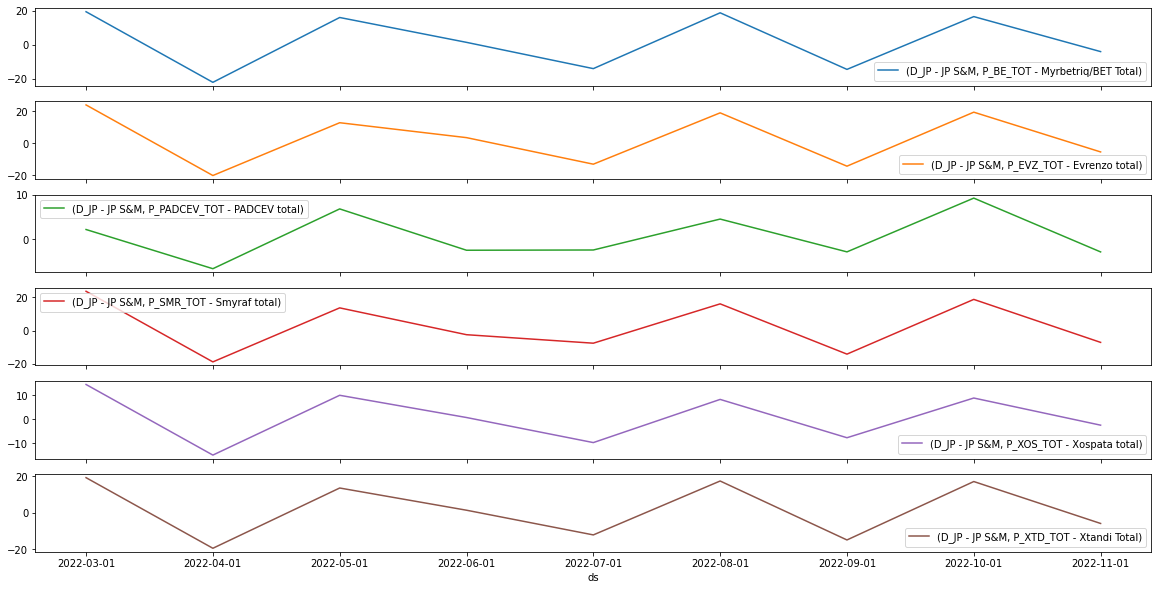

In [90]:
pd.pivot_table(data2.reset_index(),
               index='ds', columns=['product', 'region'], values='diff1'
              ).plot(subplots=True, figsize=(20,10))

In [1]:
######################
# FIND YEARLY SUM
######################
# Filter data for 2022
data3=data[(data['ds']>='2022-09-01') & (data['ds']<='2022-11-01')]

data3=data3.fillna(0)
data3=data3.groupby(['product', 'region'])['bpc_value', 'prod_value'].apply(lambda x : x.astype(int).sum()).reset_index()

# Get percentage difference
data3['diff1'] = ((data3['prod_value']-data3['bpc_value']) / data3['bpc_value']) * 100

data3

NameError: name 'data' is not defined